In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn; seaborn.set()
import pystan
import re
from scipy import stats as sts

import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

In [2]:
responses = pd.read_csv("Responses.csv")

In [3]:
# dictionary of exchange rates (converting all prices to USD)
exchange_rates = {"EUR": 1.16, "Won": 0.00084, "GBP": 1.37}

# dropping irrelevant columns
responses = responses.drop(["Timestamp", "Email Address", "Your name", 
           "Grocery store name and street address (or URL if shopping online)"], axis=1)

In [4]:
products = ["Apples", "Bananas", "Tomatoes", "Potatoes", 
            "Flour", "Rice", "Milk", "Butter", "Eggs",
            "Chicken breasts"]
def preprocess(data):
    data.rename(columns={"Country where you (and the grocery store) are": "country",
                         "Currency (e.g. EUR, GBP, USD)": "currency",
                         "Price perception of the store brand": "perception",
                         "Average rental price near the grocery store": "rental_price"},
                         inplace=True)
    # columns that are not affected
    upd_colnames = list(data.columns[:4])
    # change column names
    idx, count = 0, 1
    # iterate through the price/quantity columns for each product
    for colname in data.columns[4:]:
        # update the column names
        if "quantity" in colname:
            colname = f"{products[idx]}-{count} quantity"
            upd_colnames.append(colname)
        if "price" in colname:
            colname = f"{products[idx]}-{count} price" 
            upd_colnames.append(colname)
            count += 1
            
        if count > 3:
            idx += 1
            count = 1
    # assign new names to the columns in the dataset        
    data.columns = upd_colnames    
    idx1, count1 = 0, 1   
    # standardize the price and weight (1kg, 1l or 1 item)
    for _ in range(4, len(data.columns), 2):
        data[f"{products[idx1]}-{count1} price"] /= data[f"{products[idx1]}-{count1} quantity"]
        data[f"{products[idx1]}-{count1} quantity"] /= data[f"{products[idx1]}-{count1} quantity"]
        data[f"{products[idx1]}-{count1} price"] = np.round(data[f"{products[idx1]}-{count1} price"], 2)
        
        count1 += 1
        if count1 > 3:
            idx1 += 1
            count1 = 1
            
            
    # After the analysis of the responses, I realized that entry 4 mentioned currency
    # as Korean Won but actually has prices in USD (e.g., if it was in Korean Won, all
    # groceries would be super cheap (a few cents), which is definitely not the case for 
    # South Korea). Thus, I will remove the entry because it also has an average rental 
    # price mentioned for squared meter and I don't know what the average area of the 
    # real estate is.
    data.drop(4, axis=0, inplace=True)
    
    # also dropping rows 27, 28 because the average rental price mentioned there is 0
    data.drop([27, 28], axis=0, inplace=True)
    
    # process the rental prices
    upd_rental_price = []
    for val in data["rental_price"]:
        # remove commas
        if "," in val:
            val.replace(",", "")
        # assign nan values to entries that have something else than a numeric value
        try:
            val = int(val)
            
        except:
            val = np.nan
        upd_rental_price.append(val) 
    data["rental_price"] = np.array(upd_rental_price)
    # drop columns that have nan values
    data = data[data["rental_price"].notna()]
            
    # fix the city/country inconsistency
    upd_country = []
    for idx, name in enumerate(data["country"]):
        if name.lower().strip() in ["germany", "berlin", "berlin, germany"]:
            upd_country.append("Germany")
        elif name.lower().strip() in ["london", "united kindom", "united kingdom", "uk"]:
            upd_country.append("United Kingdom")
        else:
            upd_country.append(name)
         
    data.insert(0, "Country", upd_country, True)
    data.drop("country", axis=1, inplace=True)
    
    # While looking at the prices thoroughly, I noticed that entries 5 and 6 have
    # insane prices for eggs (1 egg for 20-30 GBP). After examining the data for the 
    # stores from the same chain and location, I realized that the student who entered
    # the values forgot to separate digits from decimals. Later on, I found another typos,
    # so I decided to remove the columns from the analysis to prevent the model from outliers.
    
    data.drop([5,6], axis=0, inplace=True)
   
    # convert the currencies to USD
    cols_with_price = [True if "price" in data.columns[i].lower() 
                  else False for i in range(data.shape[1])]
    cols_with_price = data.columns[cols_with_price]
    for currency, ex_rate in exchange_rates.items():
        data.loc[data["currency"]==currency, cols_with_price] *= ex_rate
        data.loc[data["currency"]==currency, "currency"] = "USD"
        
    # calculate the average product price for each store 
    entry_avgs = []
    idx2 = 0 
    for price in range(5, len(data.columns), 6):
        res = np.sum([data.iloc[:, price], 
                   data.iloc[:, price+2], 
                   data.iloc[:, price+4]], 
                   axis=0)/3
        entry_avgs.append(res)
        
    prod_avgs = []
    for prod in entry_avgs:
        # take the mean of each column without considering nan entries
        avg = np.nanmean(prod)
        prod_avgs.append(avg)
                
    # average values for each product to substitute NaN values
    d = {"Apples-1 quantity":1, "Apples-1 price":prod_avgs[0], "Apples-2 quantity":1, "Apples-2 price":prod_avgs[0],
         "Apples-3 quantity":1, "Apples-3 price":prod_avgs[0], "Bananas-1 quantity":1, "Bananas-1 price":prod_avgs[1],
         "Bananas-2 quantity":1, "Bananas-2 price":prod_avgs[1], "Bananas-3 quantity":1, "Bananas-3 price":prod_avgs[1],
         "Tomatoes-1 quantity":1, "Tomatoes-1 price":prod_avgs[2], "Tomatoes-2 quantity":1, "Tomatoes-2 price":prod_avgs[2],
         "Tomatoes-3 quantity":1, "Tomatoes-3 price":prod_avgs[2], "Potatoes-1 quantity":1, "Potatoes-1 price":prod_avgs[3],
         "Potatoes-2 quantity":1, "Potatoes-2 price":prod_avgs[3], "Potatoes-3 quantity":1, "Potatoes-3 price":prod_avgs[3],
         "Flour-1 quantity":1, "Flour-1 price":prod_avgs[4], "Flour-2 quantity":1, "Flour-2 price":prod_avgs[4],
         "Flour-3 quantity":1, "Flour-3 price":prod_avgs[4], "Rice-1 quantity":1, "Rice-1 price":prod_avgs[5],
         "Rice-2 quantity":1, "Rice-2 price":prod_avgs[5], "Rice-3 quantity":1, "Rice-3 price":prod_avgs[5],
         "Milk-1 quantity":1, "Milk-1 price":prod_avgs[6], "Milk-2 quantity":1, "Milk-2 price":prod_avgs[6],
         "Milk-3 quantity":1, "Milk-3 price":prod_avgs[6], "Butter-1 quantity":1, "Butter-1 price":prod_avgs[7],
         "Butter-2 quantity":1, "Butter-2 price":prod_avgs[7], "Butter-3 quantity":1, "Butter-3 price":prod_avgs[7],
         "Eggs-1 quantity":1, "Eggs-1 price":prod_avgs[8], "Eggs-2 quantity":1, "Eggs-2 price":prod_avgs[8],
         "Eggs-3 quantity":1, "Eggs-3 price":prod_avgs[8], "Chicken breasts-1 quantity":1, 
         "Chicken breasts-1 price":prod_avgs[9], "Chicken breasts-2 quantity":1, "Chicken breasts-2 price":prod_avgs[9], 
         "Chicken breasts-3 quantity":1, "Chicken breasts-3 price":prod_avgs[9]}
    
    # fill nan values with column means
    data = data.fillna(value=d)
    
    # encode store types and countries
    data["perception_coded"] = data["perception"].astype("category").cat.codes
    data["country_coded"] = data["Country"].astype("category").cat.codes
    
    return data
    
processed = preprocess(responses)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [5]:
# transpose the array and extract the country, perception and price of each product
product_info = pd.DataFrame(columns=["country", "perception", "product", "price"])
prod_code = 0
prod_count = 1

for col in range(5, 64, 2):
    for row in range(0, processed.shape[0]):
        # last column
        country = processed.iloc[row, processed.shape[1]-1].astype("int64") + 1
        # second-to-last column
        perception = processed.iloc[row, processed.shape[1]-2] + 1
        # indexing according to the products array
        product = prod_code + 1
        price = round(processed.iloc[row, col],2)
        product_info = product_info.append({"country": country, "perception": perception, 
                              "product": product, "price": price},ignore_index=True)
    prod_count += 1
    if prod_count > 3:
        prod_count = 1
        prod_code += 1

# convert column types to integer representation
product_info["country"] = product_info["country"].astype("int64")
product_info["perception"] = product_info["perception"].astype("int64")
product_info["product"] = product_info["product"].astype("int64")
        
product_info.head()

,country,perception,product,price
0,1,1,1,1.29
1,1,1,1,2.31
2,1,3,1,3.47
3,1,3,1,3.47
4,1,3,1,3.47


# Model Setup

## Base price (prior)

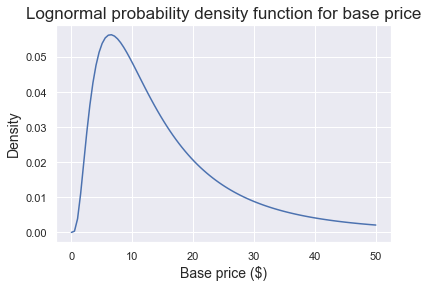

In [6]:
store_prior = sts.lognorm(s=0.8, scale=np.exp(2.5))
x = np.linspace(0, 50, 100)
plt.plot(x, store_prior.pdf(x))
plt.title("Lognormal probability density function for base price", size=17)
plt.xlabel('Base price ($)', size=14)
plt.ylabel('Density', size=14)
plt.show()

## Store multiplier (prior)

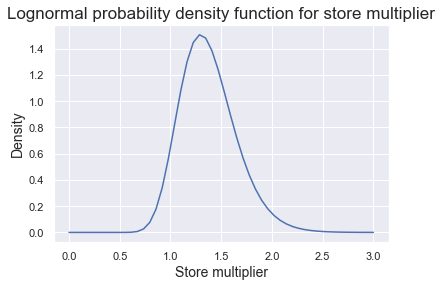

In [7]:
# Lognormal prior for store type
store_prior = sts.lognorm(s=0.2, scale=np.exp(0.3))
x = np.linspace(0, 3, 50)
plt.plot(x, store_prior.pdf(x))
plt.title("Lognormal probability density function for store multiplier", size=17)
plt.xlabel('Store multiplier', size=14)
plt.ylabel('Density', size=14)
plt.show()

## Country multiplier (prior)

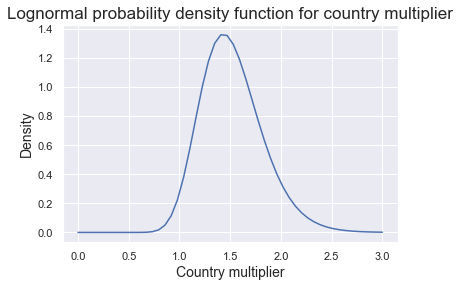

In [8]:
store_prior = sts.lognorm(s=0.2, scale=np.exp(0.4))
x = np.linspace(0, 3, 50)
plt.plot(x, store_prior.pdf(x))
plt.title("Lognormal probability density function for country multiplier", size=17)
plt.xlabel('Country multiplier', size=14)
plt.ylabel('Density', size=14)
plt.show()

## Stan Model

In [9]:
stan_code= """
// The data block contains all known quantities - typically the observed data and any constant hyperparameters.
data {
    // HYPERPARAMETERS: 
    // base price
    real<lower=0> price_alpha;      
    real<lower=0> price_beta;
    
    // store multiplier
    real<lower=0> store_alpha;      
    real<lower=0> store_beta;   
    
    // country multiplier
    real<lower=0> country_alpha;    
    real<lower=0> country_beta;   
    
    // variance for the likelihood function
    real alpha_var; 
    real beta_var;
    
    // DATA:
    int<lower=1> products;      // data.shape[1], num of cols 
    int<lower=1> obs;           // data.shape[0]; num of rows
    int<lower=1> stores;        // store perceptions (3)
    int<lower=1> countries;   
    // vectors
    int<lower=1> countries_v[obs]; // vector of the country of every observation
    int<lower=1> perceptions_v[obs];    // vector of the perception of every observation
    int<lower=1> products_v[obs];  // vector of the product type of every observation
    real prices_v[obs];    // vector of prices for each observation
   
}


// The parameters block contains all unknown quantities - typically the parameters of the model. 
parameters {
    real<lower=0> base_prices[products];  // price pre
    real<lower=0> store_mult[stores];   // manifests unknown multiplier for store
    real<lower=0> country_mult[countries];   // manifests unknown multiplier for country
    real<lower=0> sigma; // variance for the normal distribution 
}


// The model block contains all probability distributions in the model.
model {
    // base price prior
    for (i in 1:products) {
        base_prices[i] ~ lognormal(price_alpha, price_beta);  
        
    }
     // country multiplier prior
    for (i in 1:countries) {
        country_mult[i] ~ lognormal(country_alpha, country_beta);
    }
    // store multiplier prior
    for (i in 1:stores) {
        store_mult[i] ~ lognormal(store_alpha, store_beta);
        
    }
    // variance for the likelihood function
    sigma ~ gamma(alpha_var, beta_var);
    
    // likelihood:
    for (i in 1:obs) {
                    prices_v[i] ~ normal(base_prices[products_v[i]]*\
                            store_mult[perceptions_v[i]]*\
                            country_mult[countries_v[i]], \
                            sigma);  
    }                                        

}

"""

In [10]:
model = pystan.StanModel(model_code = stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d080855dfb5bb9104704be5ab8234beb NOW.


In [11]:
# lists of countries (coded), store perceptions(coded), products(coded) and their prices
countries_lst = product_info['country'].tolist()
perceptions_lst = product_info['perception'].tolist()
products_lst = product_info['product'].tolist()
prices_lst = product_info['price'].tolist()

In [12]:
model_data = {
    'price_alpha': 2.5,
    'price_beta': 0.8,
    
    'store_alpha': 0.3,
    'store_beta': 0.2,
    
    'country_alpha': 0.4,
    'country_beta': 0.2,
    
    'alpha_var': 2,
    'beta_var':0.5,
    
    'products': 10,
    'obs': product_info.shape[0],
    'stores': 3,
    'countries': 3,
    
    'countries_v': countries_lst,
    'perceptions_v': perceptions_lst, 
    'products_v': products_lst,
    'prices_v': prices_lst 
    
}

res = model.sampling(data = model_data)
res

Inference for Stan model: anon_model_d080855dfb5bb9104704be5ab8234beb.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
base_prices[1]    3.42    0.02   0.53   2.51   3.04   3.36   3.76   4.55    779   1.01
base_prices[2]    1.94    0.01   0.35   1.33    1.7   1.91   2.16   2.68    894    1.0
base_prices[3]    5.28    0.03   0.78   3.92   4.73   5.21    5.8   6.95    687   1.01
base_prices[4]    1.69    0.01   0.33   1.14   1.46   1.65   1.89   2.39   1000    1.0
base_prices[5]    1.48  8.8e-3    0.3   0.97   1.27   1.46   1.67   2.14   1193    1.0
base_prices[6]    4.25    0.02   0.65   3.14   3.78   4.19   4.66   5.63    708   1.01
base_prices[7]    1.32  8.4e-3   0.28   0.83   1.12    1.3   1.48   1.93   1099   1.01
base_prices[8]    9.17    0.05   1.33   6.86    8.2   9.02  10.04  11.97    665   1.01
base_prices[9]    0.66  4.9e

In [13]:
preds = res.extract()

In [14]:
countries = ["Germany", "United Kingdom", "United States"]
perceptions = ["Budget (cheap)", "Mid-range", "Luxury (expensive)"]

## Basic average price for each product

In [15]:
print(preds['base_prices'].shape)

(4000, 10)


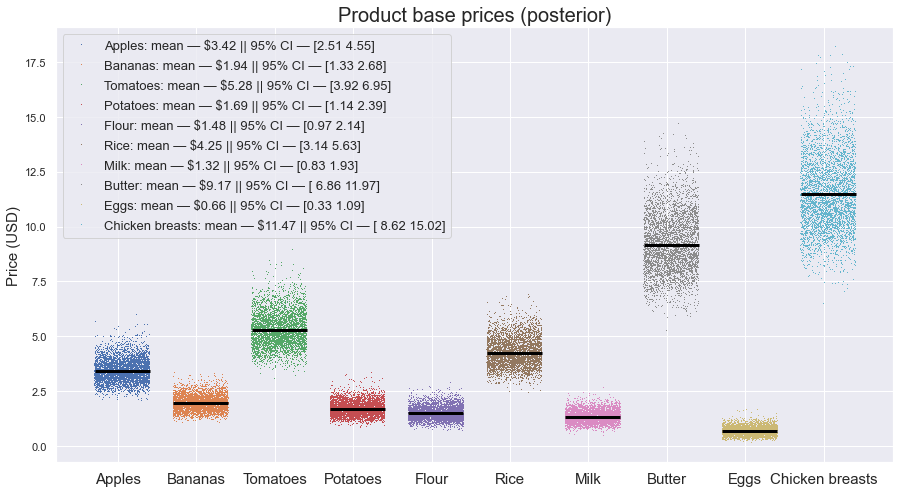

In [16]:
plt.figure(figsize=(15,8))
for i in range(len(products)):
    x = np.linspace(i+0.7, i+1.4, 4000)
    # 95% CI
    lower, upper = np.percentile(preds['base_prices'][:, i], [2.5, 97.5])
    plt.plot(x, preds['base_prices'][:,i], ',', 
             label=f"{products[i]}: mean — ${np.round(np.mean(preds['base_prices'][:,i]),2)}" 
             f" || 95% CI — {np.round([lower, upper], 2)}")
    # plot the mean posterior base price
    plt.plot(i+1.05, np.mean(preds['base_prices'][:,i]), markersize = 55, 
             color = 'black', marker ='_', mew=3)
          
plt.title("Product base prices (posterior)", size=20)
plt.ylabel("Price (USD)", size=15)
plt.xticks([1,2,3,4,5,6,7,8,9,10], products,size=15)
plt.legend(prop={"size":13})   
plt.show()

## Impact of the grocery store brand

In [17]:
print(preds['store_mult'].shape)

(4000, 3)


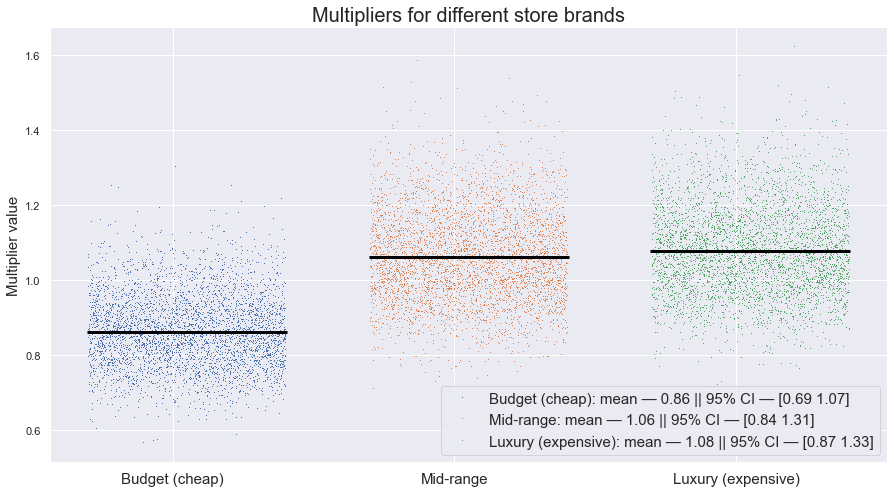

In [18]:
plt.figure(figsize=(15,8))
for i in range(len(perceptions)):
    x = np.linspace(i+0.7, i+1.4, 4000)
    # 95% CI
    lower, upper = np.percentile(preds['store_mult'][:, i], [2.5, 97.5])
    plt.plot(x, preds['store_mult'][:,i], ',', 
             label=f"{perceptions[i]}: mean — {np.round(np.mean(preds['store_mult'][:,i]),2)}" 
             f" || 95% CI — {np.round([lower, upper], 2)}")
    # plot the mean posterior base price
    plt.plot(i+1.05, np.mean(preds['store_mult'][:,i]), markersize = 200, 
             color = 'black', marker ='_', mew=3)
          
plt.title("Multipliers for different store brands", size=20)
plt.ylabel("Multiplier value", size=15)
plt.xticks([1,2,3], perceptions,size=15)
plt.legend(prop={"size":15})   
plt.show()

## Impact of the grocery store location

In [19]:
print(preds['country_mult'].shape)

(4000, 3)


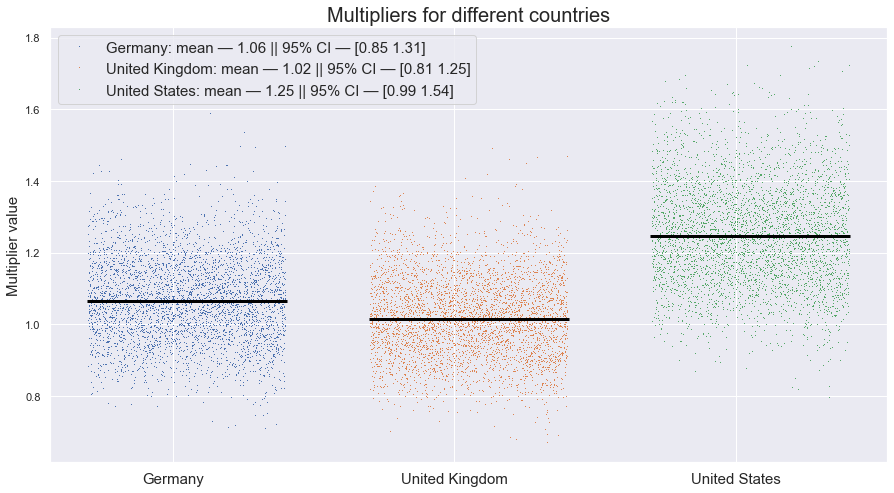

In [20]:
plt.figure(figsize=(15,8))
for i in range(len(countries)):
    x = np.linspace(i+0.7, i+1.4, 4000)
    # 95% CI
    lower, upper = np.percentile(preds['country_mult'][:, i], [2.5, 97.5])
    plt.plot(x, preds['country_mult'][:,i], ',', 
             label=f"{countries[i]}: mean — {np.round(np.mean(preds['country_mult'][:,i]),2)}" 
             f" || 95% CI — {np.round([lower, upper], 2)}")
    # plot the mean posterior base price
    plt.plot(i+1.05, np.mean(preds['country_mult'][:,i]), markersize = 200, 
             color = 'black', marker ='_', mew=3)
          
plt.title("Multipliers for different countries", size=20)
plt.ylabel("Multiplier value", size=15)
plt.xticks([1,2,3], countries,size=15)
plt.legend(prop={"size":15})   
plt.show()

# Correlation of price variation by store location and rental prices

In [22]:
# mean values for country multipliers
country_multipliers_avg = np.array([1.06, 1.02, 1.25])
# mean values for rental prices in every country
germany_rental = np.mean(processed[processed["Country"]=="Germany"]["rental_price"])
uk_rental = np.mean(processed[processed["Country"]=="United Kingdom"]["rental_price"])
usa_rental = np.mean(processed[processed["Country"]=="United States"]["rental_price"])

# normalizing the rental price values
rental = np.array([germany_rental, uk_rental, usa_rental])
rental /= np.max(rental)

# calculating the correlation coefficient
print(np.corrcoef(country_multipliers_avg, rental))

[[1.         0.50561147]
 [0.50561147 1.        ]]
